In [ ]:
!python3.11 -m pip install --upgrade pip
!pip install --upgrade lightgbm
!pip install MLB-StatsAPI
!pip install tensorflow scikit-learn
!pip install matplotlib scikit-learn

In [1]:
import numpy as np
import pandas as pd
import statsapi
import matplotlib.pyplot as plt
import csv
import sys

import lightgbm as lgbm
import structureboost as stb
import ml_insights as mli
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from structureboost import log_loss
pd.set_option("display.max_columns",1000)
pd.set_option("display.max_rows",1000)

In [2]:
df = pd.read_csv('df_bp9_new.csv')

/var/folders/4n/m6y9jtrx6m1_59wkdvlnxsm80000gn/T/ipykernel_6354/3503072021.py:1: DtypeWarning: Columns (13,14,15,19,85,87,159,198) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('df_bp9_new.csv')


In [3]:
df = pd.concat([df, pd.get_dummies(df['team_h'], prefix='stadium')], axis=1)

In [4]:
for col in df.columns:
    print(col)

date
dblheader_code
day_of_week
team_v
league_v
game_no_v
team_h
league_h
game_no_h
runs_v
runs_h
outs_total
day_night
completion_info
forfeit_info
protest_info
ballpark_id
attendance
game_minutes
linescore_v
linescore_h
AB_v
H_v
2B_v
3B_v
HR_v
RBI_v
SH_v
SF_v
HBP_v
BB_v
IBB_v
SO_v
SB_v
CS_v
GIDP_v
CI_v
LOB_v
P_num_v
ERind_v
ERteam_v
WP_v
balk_v
PO_v
ASST_v
ERR_v
PB_v
DP_v
TP_v
AB_h
H_h
2B_h
3B_h
HR_h
RBI_h
SH_h
SF_h
HBP_h
BB_h
IBB_h
SO_h
SB_h
CS_h
GIDP_h
CI_h
LOB_h
P_num_h
ERind_h
ERteam_h
WP_h
balk_h
PO_h
ASST_h
ERR_h
PB_h
DP_h
TP_h
ump_HB_id
ump_HB_name
ump_1B_id
ump_1B_name
ump_2B_id
ump_2B_name
ump_3B_id
ump_3B_name
ump_LF_id
ump_LF_name
ump_RF_id
ump_RF_name
mgr_id_v
mgr_name_v
mgr_id_h
mgr_name_h
pitcher_id_w
pitcher_name_w
pitcher_id_l
pitcher_name_l
pitcher_id_s
pitcher_name_s
GWRBI_id
GWRBI_name
pitcher_start_id_v
pitcher_start_name_v
pitcher_start_id_h
pitcher_start_name_h
batter1_name_v
batter1_id_v
batter1_pos_v
batter2_name_v
batter2_id_v
batter2_pos_v
batter3_name_v
batt

In [5]:
team_record = {}

def get_team_record(season, team_h, team_v, home_win):

    record = pd.Series([0] * 4, dtype='int32')


    found_record = False

    if team_h in team_record:

        if season in team_record[team_h]:

            record[0] = team_record[team_h][season]['wins']
            record[1] = team_record[team_h][season]['losses']

    if found_record == False:

        record[0] = 0
        record[1] = 0

    found_record = False

    if team_v in team_record:

        if season in team_record[team_v]:

            found_record = True
            record[2] = team_record[team_v][season]['wins']
            record[3] = team_record[team_v][season]['losses']

    if found_record == False:

        record[2] = 0
        record[3] = 0

    if team_h not in team_record:

        team_record[team_h] = {}

    if season not in team_record[team_h]:

        team_record[team_h][season] = { 'wins': 0, 'losses': 0 }

    if team_v not in team_record:

        team_record[team_v] = {}

    if season not in team_record[team_v]:

        team_record[team_v][season] = { 'wins': 0, 'losses': 0 }


    team_record[team_h][season]['wins'] += home_win
    team_record[team_h][season]['losses'] += 1 - home_win

    team_record[team_v][season]['wins'] += 1 - home_win
    team_record[team_v][season]['losses'] += home_win

    return record


df[['home_team_wins', 'home_team_losses', 'away_team_wins', 'away_team_losses']] = df.apply(lambda row: get_team_record(str(row['date'])[0:4], row['team_h'], row['team_v'], int(row['home_victory'])), axis=1, result_type='expand')

In [6]:
team_win_streak = {

}

def get_win_streak(home_team, visiting_team, home_team_win, ret_home_win_streak):

    prev_home_win_rate = 0
    prev_visitor_win_rate = 0

    if home_team in team_win_streak:
        
        prev_home_win_rate = team_win_streak[home_team]

    if visiting_team in team_win_streak:
        
        prev_visitor_win_rate = team_win_streak[visiting_team]

    if home_team not in team_win_streak:

        if home_team == 1:

            team_win_streak[home_team] = 1
            team_win_streak[visiting_team] = -1

        else:

            team_win_streak[home_team] = -1
            team_win_streak[visiting_team] = 1

    elif visiting_team not in team_win_streak:

        if home_team == 1:

            team_win_streak[home_team] = 1
            team_win_streak[visiting_team] = -1

        else:

            team_win_streak[home_team] = -1
            team_win_streak[visiting_team] = 1

    else:

        if home_team_win == 1:

            # The home team was on a losing streak and now won the game
            if prev_home_win_rate < 0:
                team_win_streak[home_team] = 1
            # The home team was on a winning streak and won the game
            else:
                team_win_streak[home_team] += 1

            # The visiting team was on a winning streak and now lost the game
            if prev_visitor_win_rate > 0:
                team_win_streak[visiting_team] = -1
            # The visiting team was on a losing streak and lost the game
            else:
                team_win_streak[visiting_team] += -1


        else:

            # The home team was on a winning streak and now lost the game
            if prev_home_win_rate > 0:
                team_win_streak[home_team] = -1
            # The home team was on a losing streak and lost the game
            else:
                team_win_streak[home_team] += -1

            # The visiting team was on a losing streak and now won the game
            if prev_visitor_win_rate < 0:
                team_win_streak[visiting_team] = 1
            # The visiting team was on a winning streak and won the game
            else:
                team_win_streak[visiting_team] += 1


    if ret_home_win_streak:
        return prev_home_win_rate
    else:
        return prev_visitor_win_rate

df['home_win_streak'] = df.apply(lambda row: get_win_streak(row['team_h'], row['team_v'], row['home_victory'], True), axis=1)

team_win_streak = {}

df['visitor_win_streak'] = df.apply(lambda row: get_win_streak(row['team_h'], row['team_v'], row['home_victory'], False), axis=1)

In [7]:
df['month'] = df['date'].apply(lambda x: str(x)[4:6])
df['day'] = df['date'].apply(lambda x: str(x)[6:8])
df['year'] = df['date'].apply(lambda x: str(x)[0:4])

df.month.unique()

cumulative_runs = {}
game_counts = {}

def calculate_avg(team, runs, month, season):

    if month <= '06':

        if season not in cumulative_runs:

            cumulative_runs[season] = { team: runs }
            game_counts[season] = { team: 1 }

        elif team not in cumulative_runs[season]:

            cumulative_runs[season][team] = runs
            game_counts[season][team] = 1

        else:

            cumulative_runs[season][team] += runs
            game_counts[season][team] += 1

        season = str(int(season) - 1)

        if season not in cumulative_runs:
            return None

        avg = cumulative_runs[season][team] / game_counts[season][team]

        return avg

    else:

        if season not in cumulative_runs:
            print(season, month)
            sys.exit()

        if team not in cumulative_runs[season]:
            print("ERROR: SOME HOW")
            return None

        avg = cumulative_runs[season][team] / game_counts[season][team]

        cumulative_runs[season][team] += runs
        game_counts[season][team] += 1

        return avg


df['avg_runs_v'] = df.apply(lambda row: calculate_avg(row['team_v'], row['runs_v'], row['month'], row['season']), axis=1 )
df['avg_runs_h'] = df.apply(lambda row: calculate_avg(row['team_h'], row['runs_h'], row['month'], row['season']), axis=1 )

In [8]:

cumulative_runs = {}
game_counts = {}

def calc_runs_allowed(runs_scored_on_team, team, month, season):


    if month <= '06':

        if season not in cumulative_runs:

            cumulative_runs[season] = {
                team: runs_scored_on_team
            }

            game_counts[season] = {
                team: 1
            }

        elif team not in cumulative_runs[season]:

            cumulative_runs[season][team] = runs_scored_on_team
            game_counts[season][team] = 1

        else:

            cumulative_runs[season][team] += runs_scored_on_team
            game_counts[season][team] += 1

        season = str(int(season) - 1)

        if season not in cumulative_runs:
            return None

        avg = cumulative_runs[season][team] / game_counts[season][team]

        return avg

    else:

        if season not in cumulative_runs:
            print(season, month)
            sys.exit()

        if team not in cumulative_runs[season]:
            print("ERROR: SOME HOW")
            return None

        avg = cumulative_runs[season][team] / game_counts[season][team]

        cumulative_runs[season][team] += runs_scored_on_team
        game_counts[season][team] += 1

        return avg

df['avg_runs_allowed_v'] = df.apply(lambda row: calc_runs_allowed(row['runs_h'], row['team_v'], row['month'], row['season']), axis=1 )
df['avg_runs_allowed_h'] = df.apply(lambda row: calc_runs_allowed(row['runs_v'], row['team_h'], row['month'], row['season']), axis=1 )

In [ ]:
import os
import json
import sys

data = {

}

if os.path.exists('player_data.json'):

    with open('player_data.json', 'r') as f:

        data = json.load(f)

else:

    sys.exit("Could not find player_data.json")

if len(data) == 0:
    sys.exit("No data in player_data.json")

player_trailing_stats = {

}

def get_player_trailing_avg(row_index, game_trailing_avg):

    player_stats_series = pd.Series([np.nan] * 18, dtype='float64')  # Initialize with NaNs

    row_index = str(row_index)

    i = 0

    if row_index in data:

        for team_type in data[row_index]:

            for player_id in data[row_index][team_type]:

                if i >= 18:
                    break

                if player_id not in player_trailing_stats:
                        player_stats_series[i] = 0
                else:

                    if sum(player_trailing_stats[player_id]['at_bats']) == 0:
                        player_stats_series[i] = 0
                    else:
                        player_stats_series[i] = sum(player_trailing_stats[player_id]['hits']) / sum(player_trailing_stats[player_id]['at_bats'])

                i += 1  # Increment for each player


                player_data = data[row_index][team_type][player_id]

                if player_id not in player_trailing_stats:

                    player_trailing_stats[player_id] = {
                        'hits': [int(player_data['hits'])],
                        'at_bats': [int(player_data['at_bats'])]
                    }

                else:

                    if len(player_trailing_stats[player_id]['hits']) >= game_trailing_avg:

                        player_trailing_stats[player_id]['hits'].pop(0)
                        player_trailing_stats[player_id]['at_bats'].pop(0)

                    player_trailing_stats[player_id]['hits'].append(int(player_data['hits']))
                    player_trailing_stats[player_id]['at_bats'].append(int(player_data['at_bats']))



    else:

        print("No player data for row index", row_index)

    if i != 18:

        print("ERROR: i != 18, i: ", i)

        print(data[row_index])
        sys.exit()

    return player_stats_series

df[['home_player_avg_one_ten', 'home_player_avg_two_ten',
    'home_player_avg_three_ten', 'home_player_avg_four_ten',
    'home_player_avg_five_ten', 'home_player_avg_six_ten',
    'home_player_avg_seven_ten', 'home_player_avg_eight_ten',
    'home_player_avg_nine_ten',
    'away_player_avg_one_ten','away_player_avg_two_ten',
    'away_player_avg_three_ten', 'away_player_avg_four_ten',
    'away_player_avg_five_ten', 'away_player_avg_six_ten',
    'away_player_avg_seven_ten', 'away_player_avg_eight_ten',
    'away_player_avg_nine_ten'
    ]] = df.apply(lambda row:
        pd.Series(get_player_trailing_avg(row.name, 10)), axis=1)

player_trailing_stats = {}

df[['home_player_avg_one_five', 'home_player_avg_two_five',
    'home_player_avg_three_five', 'home_player_avg_four_five',
    'home_player_avg_five_five', 'home_player_avg_six_five',
    'home_player_avg_seven_five', 'home_player_avg_eight_five',
    'home_player_avg_nine_five',
    'away_player_avg_one_five','away_player_avg_two_five',
    'away_player_avg_three_five', 'away_player_avg_four_five',
    'away_player_avg_five_five', 'away_player_avg_six_five',
    'away_player_avg_seven_five', 'away_player_avg_eight_five',
    'away_player_avg_nine_five'
    ]] = df.apply(lambda row:
        pd.Series(get_player_trailing_avg(row.name, 5)), axis=1)


player_trailing_stats = {}

df[['home_player_avg_one_twenty', 'home_player_avg_two_twenty',
    'home_player_avg_three_twenty', 'home_player_avg_four_twenty',
    'home_player_avg_five_twenty', 'home_player_avg_six_twenty',
    'home_player_avg_seven_twenty', 'home_player_avg_eight_twenty',
    'home_player_avg_nine_twenty',
    'away_player_avg_one_twenty','away_player_avg_two_twenty',
    'away_player_avg_three_twenty', 'away_player_avg_four_twenty',
    'away_player_avg_five_twenty', 'away_player_avg_six_twenty',
    'away_player_avg_seven_twenty', 'away_player_avg_eight_twenty',
    'away_player_avg_nine_twenty'
    ]] = df.apply(lambda row:
        pd.Series(get_player_trailing_avg(row.name, 20)), axis=1)


In [9]:
team_trailing_stats = {}

def trailing_run_diff(runs_v, team_h, runs_h, team_v):

    trailing_run_diff = pd.Series([np.nan] * 2, dtype='float64')

    if team_h not in team_trailing_stats:
        team_trailing_stats[team_h] = []
        trailing_run_diff[0] = 0

    if team_v not in team_trailing_stats:
        team_trailing_stats[team_v] = []
        trailing_run_diff[1] = 0

    trailing_run_diff[0] = sum(team_trailing_stats[team_h])
    trailing_run_diff[1] = sum(team_trailing_stats[team_v])

    runs_v = int(runs_v)
    runs_h = int(runs_h)

    team_trailing_stats[team_h].append(runs_h - runs_v)
    team_trailing_stats[team_v].append(runs_v - runs_h)

    if len(team_trailing_stats[team_h]) > 10:
        team_trailing_stats[team_h].pop(0)
    if len(team_trailing_stats[team_v]) > 10:
        team_trailing_stats[team_v].pop(0)

    return trailing_run_diff

df[['run_diff_last_ten_home', 'run_diff_last_ten_visitor']] = df.apply(lambda row: trailing_run_diff(row['runs_v'], row['team_h'], row['runs_h'], row['team_v']), axis=1)

In [10]:
df['run_diff_last_ten_home'].describe()

count    92946.000000
mean        -0.004110
std         14.768413
min        -63.000000
25%        -10.000000
50%          0.000000
75%         10.000000
max         65.000000
Name: run_diff_last_ten_home, dtype: float64

In [11]:
df['run_diff_last_ten_visitor'].describe()

count    92946.000000
mean         0.006649
std         14.759986
min        -68.000000
25%        -10.000000
50%          0.000000
75%         10.000000
max         63.000000
Name: run_diff_last_ten_visitor, dtype: float64

In [12]:
# Get the row with the minimum value
min_row = df.loc[df['run_diff_last_ten_visitor'].idxmin()]

# Get the row with the maximum value
max_row = df.loc[df['run_diff_last_ten_visitor'].idxmax()]

# Print the rows
print("Row with minimum value:")

for i in min_row:
    print(i)

print("\nRow with maximum value:")
for i in max_row:
    print(i)

Row with minimum value:
20150907
0
Mon
ATL
NL
138
PHI
NL
138
7
2
54
N
nan
nan
nan
PHI13
15125.0
152
200300002
001010000
37
12
4
0
2
7
1
0
0
3
2
7
1
0
0
0
7
3
2
2
0
0
27
11
0
0
1
0
31
6
1
1
1
2
0
1
1
0
0
9
1
0
1
0
4
4
7
7
0
0
27
5
0
0
1
0
eddid901
Doug Eddings
johna901
Adrian Johnson
woodt901
Tom Woodring
millb901
Bill Miller
nan
(none)
nan
(none)
gonzf801
Fredi Gonzalez
mackp101
Pete Mackanin
perew001
Williams Perez
haraa001
Aaron Harang
nan
(none)
freef001
Freddie Freeman
perew001
Williams Perez
haraa001
Aaron Harang
markn001
Nick Markakis
9
olivh001
Hector Olivera
5
freef001
Freddie Freeman
3
piera001
A.J. Pierzynski
2
swisn001
Nick Swisher
7
petej002
Jace Peterson
4
simma001
Andrelton Simmons
6
bourm001
Michael Bourn
8
perew001
Williams Perez
1
hernc005
Cesar Hernandez
4
herro001
Odubel Herrera
8
altha001
Aaron Altherr
9
howar001
Ryan Howard
3
sweed001
Darnell Sweeney
7
aschc001
Cody Asche
5
ruppc001
Cameron Rupp
2
galvf001
Freddy Galvis
6
haraa001
Aaron Harang
1
nan
Y
2015
-5
0
9
2

In [13]:
team_time_zones = {
    "TOR": "Eastern",  # Toronto Blue Jays
    "ATL": "Eastern",  # Atlanta Braves
    "BAL": "Eastern",  # Baltimore Orioles
    "DET": "Eastern",  # Detroit Tigers
    "BOS": "Eastern",  # Boston Red Sox
    "MIN": "Central",  # Minnesota Twins
    "NYA": "Eastern",  # New York Yankees
    "LAN": "Pacific",  # Los Angeles Dodgers
    "CHN": "Central",  # Chicago Cubs
    "SFN": "Pacific",  # San Francisco Giants
    "PIT": "Eastern",  # Pittsburgh Pirates
    "CLE": "Eastern",  # Cleveland Guardians
    "MON": "Eastern",  # Montreal Expos (Defunct, historically Eastern)
    "SEA": "Pacific",  # Seattle Mariners
    "KCA": "Central",  # Kansas City Royals
    "PHI": "Eastern",  # Philadelphia Phillies
    "MIL": "Central",  # Milwaukee Brewers
    "CIN": "Eastern",  # Cincinnati Reds
    "NYN": "Eastern",  # New York Mets
    "HOU": "Central",  # Houston Astros (historically Central, now in American League)
    "SLN": "Central",  # St. Louis Cardinals
    "SDN": "Pacific",  # San Diego Padres
    "CHA": "Central",  # Chicago White Sox
    "TEX": "Central",  # Texas Rangers
    "CAL": "Pacific",  # California Angels (Now Los Angeles Angels)
    "OAK": "Pacific",  # Oakland Athletics
    "COL": "Mountain", # Colorado Rockies
    "FLO": "Eastern",  # Florida Marlins (Now Miami Marlins)
    "ANA": "Pacific",  # Anaheim Angels (Now Los Angeles Angels)
    "TBA": "Eastern",  # Tampa Bay Rays
    "ARI": "Mountain", # Arizona Diamondbacks
    "WAS": "Eastern",  # Washington Nationals
    "MIA": "Eastern",  # Miami Marlins
}


from datetime import datetime
import pytz

def hour_difference(timezone1, timezone2):
    """
    Returns the hour difference between two time zones.

    Parameters:
    timezone1 (str): The name of the first time zone (e.g., 'Eastern', 'Pacific').
    timezone2 (str): The name of the second time zone (e.g., 'Central', 'Mountain').

    Returns:
    int: The hour difference between the two time zones.
    """
    # Mapping shorthand names to actual time zone names
    timezone_map = {
        "Eastern": "US/Eastern",
        "Central": "US/Central",
        "Mountain": "US/Mountain",
        "Pacific": "US/Pacific",
    }
    
    # Get the actual time zones
    tz1 = pytz.timezone(timezone_map.get(timezone1))
    tz2 = pytz.timezone(timezone_map.get(timezone2))
    
    # Get the current time in UTC
    now = datetime.utcnow()
    
    # Localize the current time to each time zone
    offset1 = tz1.utcoffset(now).total_seconds() / 3600
    offset2 = tz2.utcoffset(now).total_seconds() / 3600
    
    # Calculate and return the hour difference
    return abs(int(offset1 - offset2))


df['hour_diff'] = df.apply(lambda x: hour_difference( team_time_zones[x.team_h], team_time_zones[x.team_v]), axis=1)

In [14]:
# Step 1: Extract year from the date column (already done in your code)
df['year'] = df['date'].astype('str')
df['year'] = df['year'].apply(lambda x: int(x[:4]))

# Step 2: Calculate home win rate grouped by team and year
home_win_rate = df.groupby(['team_h', 'year']).agg({'home_victory': 'mean'}).reset_index()
home_win_rate['home_win_rate'] = home_win_rate['home_victory']
home_win_rate.drop(columns=['home_victory'], inplace=True)

# Step 3: Shift the home win rate by year to get the previous year's data
home_win_rate['prev_year_home_win_rate'] = home_win_rate.groupby('team_h')['home_win_rate'].shift(1)

# Step 4: Merge the previous year's win rate back to the original DataFrame
df = pd.merge(df, home_win_rate[['team_h', 'year', 'prev_year_home_win_rate']],
              on=['team_h', 'year'],
              how='left')

In [15]:
visitor_win_rate = df.groupby(['team_v', 'year']).agg({'home_victory': 'mean'}).reset_index()
visitor_win_rate['visitor_win_rate'] = visitor_win_rate['home_victory']
visitor_win_rate.drop(columns=['home_victory'], inplace=True)

# Step 3: Shift the home win rate by year to get the previous year's data
visitor_win_rate['prev_year_visitor_win_rate'] = visitor_win_rate.groupby('team_v')['visitor_win_rate'].shift(1)

# Step 4: Merge the previous year's win rate back to the original DataFrame
df = pd.merge(df, visitor_win_rate[['team_v', 'year', 'prev_year_visitor_win_rate']],
              on=['team_v', 'year'],
              how='left')

In [16]:
df = df[~(df.prev_year_home_win_rate.isnull()) | ~(df.prev_year_visitor_win_rate.isnull())]

## Begin Modeling

In [17]:
df = df[df.run_diff!=0]
df_train = df[(df.season>1980) & (df.season<=2016) & ~(df.OBP_162_h.isnull())]
# df_train = df[(df.season>2000) & (df.season<=2016) & ~(df.OBP_162_h.isnull())]
df_valid = df[(df.season>=2017) & (df.season<=2018)]
df_test = df[df.season>=2021]

## Let's add in some lineup features

In [18]:
target = 'home_victory'

y_train = df_train[target].to_numpy()
y_valid = df_valid[target].to_numpy()
y_test = df_test[target].to_numpy()


In [19]:

class Blending:
    def __init__(self, base_model_one, base_model_two, meta_model):
        self.base_model_one = base_model_one
        self.base_model_two = base_model_two
        self.meta_model = meta_model


    def fit(self, X_train, y_train, X_val, y_val):

        self.base_model_one.fit(X_train, y_train)
        self.base_model_two.fit(X_train, y_train)


        pred_1 = self.base_model_one.predict_proba(X_val)[:, 1]
        pred_2 = self.base_model_two.predict_proba(X_val)[:, 1]


        blending_X = np.column_stack((pred_1, pred_2))
        blending_y = y_val

        self.meta_model.fit(blending_X, blending_y)

        return self

    def predict(self, X_test):
        test_pred_1 = self.base_model_one.predict_proba(X_test)[:, 1]
        test_pred_2 = self.base_model_two.predict_proba(X_test)[:, 1]

        # Create test features for the meta-learner
        test_blending_X = np.column_stack((test_pred_1, test_pred_2))

        # Use the meta-learner to make the final predictions
        final_pred = self.meta_model.predict(test_blending_X)
        return final_pred



In [20]:
def res(pred, implied_prob):

      if abs(pred - implied_prob) >= 0.1:
            return implied_prob
      return pred

def try_features(feat_set, max_depth=2):
    target = 'home_victory'
    X_train = df_train.loc[:,feat_set]
    X_valid = df_valid.loc[:,feat_set]
    X_test = df_test.loc[:,feat_set]
    # Impute missing values
    imputer = SimpleImputer(strategy='mean')  # Or 'median', 'most_frequent', etc.
    X_train = imputer.fit_transform(X_train)
    X_valid = imputer.transform(X_valid)
    X_test = imputer.transform(X_test)



    lgbm1 = lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)
    lgbm1.fit(X_train, y_train, eval_set=(X_valid, y_valid), eval_metric='logloss', 
          callbacks=[lgbm.early_stopping(stopping_rounds=50)])


    preds_lgbm_test = lgbm1.predict_proba(X_test)[:,1]
    ll_test = log_loss(y_test, preds_lgbm_test)
    result = pd.DataFrame(preds_lgbm_test, columns=['result'])

    dec_tree = DecisionTreeClassifier(max_depth=max_depth)
    log_reg = LogisticRegression(max_iter=1000)
    random_forest = RandomForestClassifier(max_depth=max_depth)

    stacking_clf = StackingClassifier(estimators=[
                                                    # ('xgb', XGBClassifier(n_estimators=1000, learning_rate=.02, max_depth=max_depth)),
                                                    # ('dec_tree', dec_tree),
                                                    ('random_forest', random_forest),
                                                    ('log_reg', log_reg)
                                                    ],
                                        final_estimator=LogisticRegression(max_iter=1000))


    blending_model = Blending(lgbm1, stacking_clf, log_reg)

    blending_model.fit(X_train, y_train, X_valid, y_valid)

    # calibrated_stacking = CalibratedClassifierCV(blending_model, method='sigmoid', cv="prefit")
    # calibrated_stacking.fit(X_valid, y_valid)

    stacking_preds = blending_model.predict(X_test)

    new_model = pd.DataFrame(stacking_preds, columns=['result'])

    implied_prob = pd.DataFrame()
    implied_prob['implied_prob_h_mid'] = df_test['implied_prob_h_mid']


    new_df = pd.DataFrame()
    new_df['our_result'] = new_model['result']
    new_df['implied_prob']  = implied_prob['implied_prob_h_mid']

#     new_df['final_result'] = new_df.apply(lambda row: res(row.our_result, row.implied_prob), axis=1)

    implied_prob['implied_prob_h_mid'] = (implied_prob['implied_prob_h_mid'] > .5).astype(int)
    result['result'] = (result['result'] > 0.5).astype(int)
    new_model['result'] = (new_model['result'] > 0.5).astype(int)

    test_df = pd.DataFrame()
    test_df['result'] = new_model['result']
    test_df['implied_prob_h_mid'] = implied_prob['implied_prob_h_mid']

#     our_accuracy_rate = round((accuracy_score(y_test, new_model['result']) * 100),2)
    our_accuracy_rate = round((accuracy_score(y_test, new_df['our_result']) * 100),2)
    yt_accuracy_rate = round((accuracy_score(y_test, result['result']) * 100), 2)

#     difference_in_accuracy = round((accuracy_score(y_test, new_model['result']) * 100) - (accuracy_score(y_test, implied_prob['implied_prob_h_mid']) * 100), 2)
    difference_in_accuracy = round((accuracy_score(y_test, new_df['our_result']) * 100) - (accuracy_score(y_test, implied_prob['implied_prob_h_mid']) * 100), 2)
    difference_in_accuracy_yt = round((accuracy_score(y_test, result['result']) * 100) - (accuracy_score(y_test, implied_prob['implied_prob_h_mid']) * 100), 2)
    vegas_accuracy_rate = round((accuracy_score(y_test, implied_prob['implied_prob_h_mid']) *100),2)

    print("YT model's accuracy score: ", yt_accuracy_rate)
    print("Vegas model's accuracy score: ", vegas_accuracy_rate)
    print("Our model's accuracy score: ", our_accuracy_rate)
    print("Difference in accuracy (YT): ", difference_in_accuracy_yt)
    print("Difference in accuracy (Our):", difference_in_accuracy)

    return yt_accuracy_rate, vegas_accuracy_rate, our_accuracy_rate, difference_in_accuracy_yt, difference_in_accuracy


In [21]:
best_features = [
        "Strt_WHIP_35_v",
        "Strt_TB_BB_perc_35_h",
        "Strt_TB_BB_perc_35_v",
        "Strt_H_BB_perc_35_h",
        "Strt_H_BB_perc_35_v",
        "Strt_SO_perc_10_h",
        "Strt_SO_perc_10_v",
        "Bpen_WHIP_75_h",
        "Bpen_WHIP_75_v",
        "Bpen_TB_BB_perc_75_h",
        "Bpen_TB_BB_perc_75_v",
        "Bpen_H_BB_perc_75_h",
        "Bpen_H_BB_perc_75_v",
        "Bpen_SO_perc_75_h",
        "Bpen_SO_perc_75_v",
        "Bpen_WHIP_35_h",
        "Bpen_WHIP_35_v",
        "Bpen_TB_BB_perc_35_h",
        "Bpen_TB_BB_perc_35_v",
        "Bpen_H_BB_perc_35_h",
        "Bpen_H_BB_perc_35_v",
        "prev_year_home_win_rate",
        "avg_runs_allowed_h",
        "avg_runs_allowed_v",
        "avg_runs_h",
        "avg_runs_v",
        "prev_year_visitor_win_rate",
        "days_between_games_h",
        # "stadium_ANA",
        # "stadium_ARI",
        # "stadium_ATL",
        # "stadium_BAL",
        # "stadium_BOS",
        # "stadium_CAL",
        # "stadium_CHA",
        # "stadium_CHN",
        # "stadium_CIN",
        # "stadium_CLE",
        # "stadium_COL",
        # "stadium_DET",
        # "stadium_FLO",
        # "stadium_HOU",
        # "stadium_KCA",
        # "stadium_LAN",
        # "stadium_MIA",
        # "stadium_MIL",
        # "stadium_MIN",
        # "stadium_MON",
        # "stadium_NYA",
        # "stadium_NYN",
        # "stadium_OAK",
        # "stadium_PHI",
        # "stadium_PIT",
        # "stadium_SDN",
        # "stadium_SEA",
        # "stadium_SFN",
        # "stadium_SLN",
        # "stadium_TBA",
        # "stadium_TEX",
        # "stadium_TOR",
        # "stadium_WAS",
        "days_between_games_v",
        "hour_diff",
        "implied_prob_h",
        "implied_prob_v",
        "implied_prob_h_mid",
        "Bpen_SO_perc_35_h",
        "Bpen_SO_perc_35_v",
        "Bpen_WHIP_10_h",
        "Bpen_WHIP_10_v",
        "Bpen_TB_BB_perc_10_h",
        "Bpen_TB_BB_perc_10_v",
        "Bpen_H_BB_perc_10_h",
        "Bpen_H_BB_perc_10_v",
        # "home_team_wins",
        # "home_team_losses",
        # "away_team_wins",
        # "away_team_losses",
        # "run_diff_last_ten_home",
        # "run_diff_last_ten_visitor",
        # "home_player_avg_one_five",
        # "home_player_avg_two_five",
        # "home_player_avg_three_five",
        # "home_player_avg_four_five",
        # "home_player_avg_five_five",
        # "home_player_avg_six_five",
        # "home_player_avg_seven_five",
        # "home_player_avg_eight_five",
        # "home_player_avg_nine_five",
        # "away_player_avg_one_five",
        # "away_player_avg_two_five",
        # "away_player_avg_three_five",
        # "away_player_avg_four_five",
        # "away_player_avg_five_five",
        # "away_player_avg_six_five",
        # "away_player_avg_seven_five",
        # "away_player_avg_eight_five",
        # "away_player_avg_nine_five",
        # "home_player_avg_one_ten",
        # "home_player_avg_two_ten",
        # "home_player_avg_three_ten",
        # "home_player_avg_four_ten",
        # "home_player_avg_five_ten",
        # "home_player_avg_six_ten",
        # "home_player_avg_seven_ten",
        # "home_player_avg_eight_ten",
        # "home_player_avg_nine_ten",
        # "away_player_avg_one_ten",
        # "away_player_avg_two_ten",
        # "away_player_avg_three_ten",
        # "away_player_avg_four_ten",
        # "away_player_avg_five_ten",
        # "away_player_avg_six_ten",
        # "away_player_avg_seven_ten",
        # "away_player_avg_eight_ten",
        # "away_player_avg_nine_ten",
        # "home_player_avg_one_twenty",
        # "home_player_avg_two_twenty",
        # "home_player_avg_three_twenty",
        # "home_player_avg_four_twenty",
        # "home_player_avg_five_twenty",
        # "home_player_avg_six_twenty",
        # "home_player_avg_seven_twenty",
        # "home_player_avg_eight_twenty",
        # "home_player_avg_nine_twenty",
        # "away_player_avg_one_twenty",
        # "away_player_avg_two_twenty",
        # "away_player_avg_three_twenty",
        # "away_player_avg_four_twenty",
        # "away_player_avg_five_twenty",
        # "away_player_avg_six_twenty",
        # "away_player_avg_seven_twenty",
        # "away_player_avg_eight_twenty",
        # "away_player_avg_nine_twenty"


    ]

### First, let's revisit our best model from our last modeling session

In [22]:
yt_accuracy_rate, vegas_accuracy_rate, our_accuracy_rate, difference_in_accuracy_yt, difference_in_accuracy = try_features(best_features)

[LightGBM] [Info] Number of positive: 43440, number of negative: 37078
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002880 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8758
[LightGBM] [Info] Number of data points in the train set: 80518, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.539507 -> initscore=0.158357
[LightGBM] [Info] Start training from score 0.158357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGB

In [23]:
df = df[df.run_diff != 0]
df = df[best_features + ['home_victory', 'season']]

In [24]:
print("df null value count: ", df[best_features].isnull().sum().sum())

df null value count:  176990


In [25]:
print(len(best_features))

41


In [26]:
df_before = df.copy()

In [27]:
imputer = SimpleImputer(strategy='mean')  # Or 'median', 'most_frequent', etc.
df[best_features] = imputer.fit_transform(df[best_features])  # Ensure that you're only imputing relevant columns

In [28]:
print(df[best_features].describe() - df_before[best_features].describe())

       Strt_WHIP_35_v  Strt_TB_BB_perc_35_h  Strt_TB_BB_perc_35_v  \
count             0.0                   0.0                   0.0   
mean              0.0                   0.0                   0.0   
std               0.0                   0.0                   0.0   
min               0.0                   0.0                   0.0   
25%               0.0                   0.0                   0.0   
50%               0.0                   0.0                   0.0   
75%               0.0                   0.0                   0.0   
max               0.0                   0.0                   0.0   

       Strt_H_BB_perc_35_h  Strt_H_BB_perc_35_v  Strt_SO_perc_10_h  \
count                  0.0                  0.0                0.0   
mean                   0.0                  0.0                0.0   
std                    0.0                  0.0                0.0   
min                    0.0                  0.0                0.0   
25%                    0.0  

In [29]:
df_before[best_features].describe()

,Strt_WHIP_35_v,Strt_TB_BB_perc_35_h,Strt_TB_BB_perc_35_v,Strt_H_BB_perc_35_h,Strt_H_BB_perc_35_v,Strt_SO_perc_10_h,Strt_SO_perc_10_v,Bpen_WHIP_75_h,Bpen_WHIP_75_v,Bpen_TB_BB_perc_75_h,Bpen_TB_BB_perc_75_v,Bpen_H_BB_perc_75_h,Bpen_H_BB_perc_75_v,Bpen_SO_perc_75_h,Bpen_SO_perc_75_v,Bpen_WHIP_35_h,Bpen_WHIP_35_v,Bpen_TB_BB_perc_35_h,Bpen_TB_BB_perc_35_v,Bpen_H_BB_perc_35_h,Bpen_H_BB_perc_35_v,prev_year_home_win_rate,avg_runs_allowed_h,avg_runs_allowed_v,avg_runs_h,avg_runs_v,prev_year_visitor_win_rate,days_between_games_h,days_between_games_v,hour_diff,implied_prob_h,implied_prob_v,implied_prob_h_mid,Bpen_SO_perc_35_h,Bpen_SO_perc_35_v,Bpen_WHIP_10_h,Bpen_WHIP_10_v,Bpen_TB_BB_perc_10_h,Bpen_TB_BB_perc_10_v,Bpen_H_BB_perc_10_h,Bpen_H_BB_perc_10_v
count,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90242.000000,46828.000000,46828.000000,46828.000000,46828.000000,90244.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000
mean,1.355417,0.446174,0.446165,0.318379,0.318360,0.167624,0.167712,1.366574,1.366301,0.459301,0.459223,0.332728,0.332670,0.197148,0.197189,1.366767,1.366821,0.458966,0.458899,0.332356,0.332354,0.538509,4.541405,4.599514,4.516751,4.472923,0.538198,1.188011,1.189299,1.123857,0.029324,0.025648,0.501838,0.197653,0.197660,1.370733,1.368135,0.457785,0.456795,0.331475,0.330930
std,0.160122,0.043765,0.043785,0.029449,0.029375,0.053135,0.053124,0.134005,0.133725,0.038443,0.038359,0.023908,0.023849,0.036090,0.036100,0.171904,0.171367,0.049290,0.049116,0.030308,0.030137,0.077750,0.556166,0.622912,0.525636,0.632493,0.081914,1.095270,1.096430,1.090349,0.125837,0.110721,0.025970,0.039887,0.039873,0.286527,0.286256,0.083033,0.082854,0.050111,0.049883
min,0.679873,0.264356,0.264192,0.184416,0.186198,0.026178,0.022222,0.902736,0.925373,0.316489,0.311757,0.241463,0.245614,0.081442,0.082011,0.802326,0.747475,0.272727,0.256065,0.220096,0.216374,0.283951,3.018349,2.743590,3.056452,2.250000,0.271605,0.000000,0.000000,0.000000,0.000000,0.000000,0.219048,0.070028,0.061688,0.415385,0.461538,0.131148,0.136364,0.128571,0.136364
25%,1.245536,0.417625,0.417293,0.298246,0.298305,0.129630,0.129630,1.273913,1.273210,0.433161,0.433012,0.316506,0.316411,0.170652,0.170880,1.248387,1.247863,0.425150,0.425000,0.311914,0.312070,0.481481,4.140496,4.169014,4.155405,4.039152,0.481481,1.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.168675,0.168699,1.173913,1.168831,0.401869,0.400000,0.298077,0.297297
50%,1.356164,0.447172,0.447059,0.317686,0.317618,0.162630,0.162791,1.361582,1.360522,0.458423,0.458440,0.332599,0.332451,0.195205,0.195223,1.359375,1.358824,0.458167,0.458221,0.332083,0.331906,0.543210,4.496031,4.555556,4.479167,4.431034,0.537500,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.195402,0.195506,1.353982,1.350000,0.455782,0.454545,0.330827,0.330357
75%,1.470041,0.474453,0.474524,0.338658,0.338710,0.200000,0.200000,1.454361,1.454061,0.485023,0.484727,0.349088,0.349078,0.221835,0.221925,1.478873,1.479339,0.491566,0.491477,0.352818,0.352705,0.592593,4.918969,5.012540,4.850746,4.863636,0.592593,1.000000,1.000000,2.000000,0.000000,0.000000,0.500000,0.224490,0.224444,1.550562,1.550000,0.512000,0.511628,0.364407,0.364407
max,2.057143,0.660156,0.653543,0.426595,0.430024,0.492891,0.466960,2.051643,2.030769,0.610849,0.606848,0.428852,0.435849,0.343368,0.343156,2.229452,2.247423,0.653153,0.669663,0.461702,0.458874,0.765432,7.017094,7.744681,6.375000,7.291667,0.790123,61.000000,61.000000,3.000000,0.827586,0.800000,0.802682,0.352041,0.362360,3.037037,2.968750,0.926829,0.909091,0.573171,0.555556


In [30]:
df.describe()

,Strt_WHIP_35_v,Strt_TB_BB_perc_35_h,Strt_TB_BB_perc_35_v,Strt_H_BB_perc_35_h,Strt_H_BB_perc_35_v,Strt_SO_perc_10_h,Strt_SO_perc_10_v,Bpen_WHIP_75_h,Bpen_WHIP_75_v,Bpen_TB_BB_perc_75_h,Bpen_TB_BB_perc_75_v,Bpen_H_BB_perc_75_h,Bpen_H_BB_perc_75_v,Bpen_SO_perc_75_h,Bpen_SO_perc_75_v,Bpen_WHIP_35_h,Bpen_WHIP_35_v,Bpen_TB_BB_perc_35_h,Bpen_TB_BB_perc_35_v,Bpen_H_BB_perc_35_h,Bpen_H_BB_perc_35_v,prev_year_home_win_rate,avg_runs_allowed_h,avg_runs_allowed_v,avg_runs_h,avg_runs_v,prev_year_visitor_win_rate,days_between_games_h,days_between_games_v,hour_diff,implied_prob_h,implied_prob_v,implied_prob_h_mid,Bpen_SO_perc_35_h,Bpen_SO_perc_35_v,Bpen_WHIP_10_h,Bpen_WHIP_10_v,Bpen_TB_BB_perc_10_h,Bpen_TB_BB_perc_10_v,Bpen_H_BB_perc_10_h,Bpen_H_BB_perc_10_v,home_victory,season
count,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000,90798.000000
mean,1.355417,0.446174,0.446165,0.318379,0.318360,0.167624,0.167712,1.366574,1.366301,0.459301,0.459223,0.332728,0.332670,0.197148,0.197189,1.366767,1.366821,0.458966,0.458899,0.332356,0.332354,0.538509,4.541405,4.599514,4.516751,4.472923,0.538198,1.188011,1.189299,1.123857,0.029324,0.025648,0.501838,0.197653,0.197660,1.370733,1.368135,0.457785,0.456795,0.331475,0.330930,0.538569,2001.476068
std,0.160122,0.043765,0.043785,0.029449,0.029375,0.053135,0.053124,0.134005,0.133725,0.038443,0.038359,0.023908,0.023849,0.036090,0.036100,0.171904,0.171367,0.049290,0.049116,0.030308,0.030137,0.077511,0.399408,0.447341,0.377483,0.454222,0.081664,1.095270,1.096430,1.090349,0.125837,0.110721,0.025970,0.039887,0.039873,0.286527,0.286256,0.083033,0.082854,0.050111,0.049883,0.498513,11.545595
min,0.679873,0.264356,0.264192,0.184416,0.186198,0.026178,0.022222,0.902736,0.925373,0.316489,0.311757,0.241463,0.245614,0.081442,0.082011,0.802326,0.747475,0.272727,0.256065,0.220096,0.216374,0.283951,3.018349,2.743590,3.056452,2.250000,0.271605,0.000000,0.000000,0.000000,0.000000,0.000000,0.219048,0.070028,0.061688,0.415385,0.461538,0.131148,0.136364,0.128571,0.136364,0.000000,1981.000000
25%,1.245536,0.417625,0.417293,0.298246,0.298305,0.129630,0.129630,1.273913,1.273210,0.433161,0.433012,0.316506,0.316411,0.170652,0.170880,1.248387,1.247863,0.425150,0.425000,0.311914,0.312070,0.481481,4.471338,4.532310,4.459627,4.408451,0.481481,1.000000,1.000000,0.000000,0.000000,0.000000,0.500000,0.168675,0.168699,1.173913,1.168831,0.401869,0.400000,0.298077,0.297297,0.000000,1992.000000
50%,1.356164,0.447172,0.447059,0.317686,0.317618,0.162630,0.162791,1.361582,1.360522,0.458423,0.458440,0.332599,0.332451,0.195205,0.195223,1.359375,1.358824,0.458167,0.458221,0.332083,0.331906,0.543210,4.541405,4.599514,4.516751,4.472923,0.538198,1.000000,1.000000,1.000000,0.000000,0.000000,0.500000,0.195402,0.195506,1.353982,1.350000,0.455782,0.454545,0.330827,0.330357,1.000000,2002.000000
75%,1.470041,0.474453,0.474524,0.338658,0.338710,0.200000,0.200000,1.454361,1.454061,0.485023,0.484727,0.349088,0.349078,0.221835,0.221925,1.478873,1.479339,0.491566,0.491477,0.352818,0.352705,0.592593,4.541405,4.599514,4.516751,4.472923,0.592593,1.000000,1.000000,2.000000,0.000000,0.000000,0.500000,0.224490,0.224444,1.550562,1.550000,0.512000,0.511628,0.364407,0.364407,1.000000,2011.000000
max,2.057143,0.660156,0.653543,0.426595,0.430024,0.492891,0.466960,2.051643,2.030769,0.610849,0.606848,0.428852,0.435849,0.343368,0.343156,2.229452,2.247423,0.653153,0.669663,0.461702,0.458874,0.765432,7.017094,7.744681,6.375000,7.291667,0.790123,61.000000,61.000000,3.000000,0.827586,0.800000,0.80

In [31]:
from sklearn.cluster import KMeans

# Apply KMeans clustering to group similar points
kmeans = KMeans(n_clusters=9, random_state=42, n_init=10, max_iter=5000)

kmeans.fit(df[best_features])  # Fit the model

df['bin'] = kmeans.predict(df[best_features])  # Assign bins to the data

df_train = df[(df.season>1980) & (df.season<=2016)]
df_valid = df[(df.season>=2017) & (df.season<=2018)]
df_test = df[df.season>=2021]

In [32]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(df[best_features])
df['cluster'] = clusters

df_train = df[(df.season>1980) & (df.season<=2016)]
df_valid = df[(df.season>=2017) & (df.season<=2018)]
df_test = df[df.season>=2021]

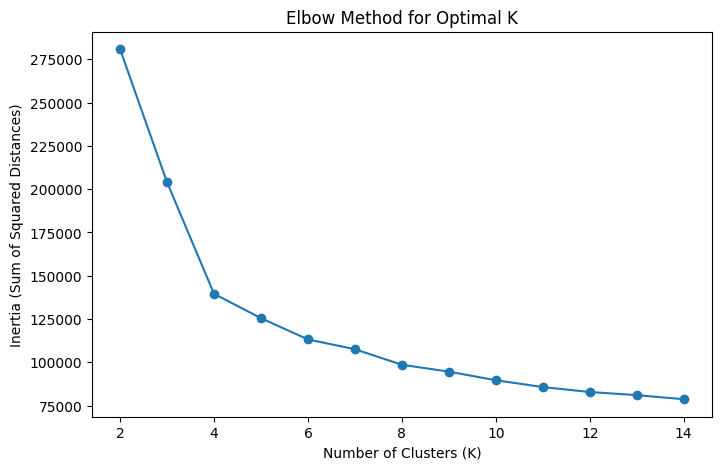

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Feature data for clustering (replace X with your actual data)
X = df_train[best_features]

# Try different numbers of clusters
inertia = []
cluster_range = range(2, 15)  # Test from 2 to 14 clusters

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia (Sum of Squared Distances)")
plt.title("Elbow Method for Optimal K")
plt.show()

In [34]:
# Merge bins with fewer samples

# df_train['bin'] = df_train['bin'].replace({2: 3})
print("Training set distribution:")
print(df_train['cluster'].nunique())
print("Validation set distribution:")
print(df_valid['cluster'].nunique())
print("Test set distribution:")
print(df_test['cluster'].nunique())

Training set distribution:
400
Validation set distribution:
58
Test set distribution:
78


In [35]:
# Check for duplicate column names
duplicate_columns = df_train.columns[df_train.columns.duplicated()]
print(f"Duplicate columns: {duplicate_columns}")

Duplicate columns: Index([], dtype='object')


In [36]:
train_bin_one = df_train[df_train['bin'] == 1]
val_bin_one = df_valid[df_valid['bin'] == 1]
test_bin_one = df_test[df_test['bin'] == 1]

print("Train Bin 1 Mean Values:\n", train_bin_one.mean(numeric_only=True))
print("Validation Bin 1 Mean Values:\n", val_bin_one.mean(numeric_only=True))
print("Test Bin 1 Mean Values:\n", test_bin_one.mean(numeric_only=True))

Train Bin 1 Mean Values:
 Strt_WHIP_35_v                   1.265834
Strt_TB_BB_perc_35_h             0.418898
Strt_TB_BB_perc_35_v             0.421403
Strt_H_BB_perc_35_h              0.299245
Strt_H_BB_perc_35_v              0.301430
Strt_SO_perc_10_h                0.183303
Strt_SO_perc_10_v                0.180864
Bpen_WHIP_75_h                   1.365412
Bpen_WHIP_75_v                   1.372765
Bpen_TB_BB_perc_75_h             0.458472
Bpen_TB_BB_perc_75_v             0.459822
Bpen_H_BB_perc_75_h              0.333859
Bpen_H_BB_perc_75_v              0.335207
Bpen_SO_perc_75_h                0.192369
Bpen_SO_perc_75_v                0.190145
Bpen_WHIP_35_h                   1.375545
Bpen_WHIP_35_v                   1.371411
Bpen_TB_BB_perc_35_h             0.458270
Bpen_TB_BB_perc_35_v             0.457078
Bpen_H_BB_perc_35_h              0.334423
Bpen_H_BB_perc_35_v              0.334114
prev_year_home_win_rate          0.537813
avg_runs_allowed_h               4.551187
avg_runs

In [37]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ObliqueDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None):
        self.max_depth = max_depth
        self.tree_ = None
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_features = X.shape[1]
        
        # Create random projection matrix
        self.projection_ = np.random.randn(n_features, n_features)
        X_projected = X @ self.projection_  # Project input features
        
        # Train standard decision tree on projected features
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth)
        self.tree_.fit(X_projected, y)
        return self
    
    def predict(self, X):
        check_is_fitted(self, 'tree_')
        X = check_array(X)
        X_projected = X @ self.projection_  # Apply same projection
        return self.tree_.predict(X_projected)
    
    def predict_proba(self, X):
        check_is_fitted(self, 'tree_')
        X = check_array(X)
        X_projected = X @ self.projection_
        return self.tree_.predict_proba(X_projected)
    
    def get_params(self, deep=True):
        return {"max_depth": self.max_depth}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

class ObliqueRandomForest(BaseEstimator, ClassifierMixin):

    def __init__(self, n_estimators=10, max_depth=None):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees_ = []
        self.classes_ = None

    def fit(self, X, y):

        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.trees_ = []
        
        for _ in range(self.n_estimators):
            tree = ObliqueDecisionTree(max_depth=self.max_depth)
            indices = np.random.choice(len(X), len(X), replace=True)  # Bootstrap sampling
            X_sample, y_sample = X[indices], y[indices]
            tree.fit(X_sample, y_sample)
            self.trees_.append(tree)
        
        return self
    
    def predict(self, X):
        check_is_fitted(self, 'trees_')
        X = check_array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees_])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    def predict_proba(self, X):
        check_is_fitted(self, 'trees_')
        X = check_array(X)
        probs = np.mean([tree.predict_proba(X) for tree in self.trees_], axis=0)
        return probs
    
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "max_depth": self.max_depth}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self


In [43]:
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

class ObliqueDecisionTree(BaseEstimator, ClassifierMixin):
    def __init__(self, max_depth=None, criterion='gini'):
        self.max_depth = max_depth
        self.criterion = criterion
        self.tree_ = None
        
    def fit(self, X, y):
        X, y = check_X_y(X, y)
        n_features = X.shape[1]
        
        # Create random projection matrix
        self.projection_ = np.random.randn(n_features, n_features)
        X_projected = X @ self.projection_  # Project input features
        
        # Train standard decision tree on projected features
        self.tree_ = DecisionTreeClassifier(max_depth=self.max_depth, criterion=self.criterion, min_samples_leaf=10)
        self.tree_.fit(X_projected, y)
        return self
    
    def predict(self, X):
        check_is_fitted(self, 'tree_')
        X = check_array(X)
        X_projected = X @ self.projection_  # Apply same projection
        return self.tree_.predict(X_projected)
    
    def predict_proba(self, X):
        check_is_fitted(self, 'tree_')
        X = check_array(X)
        X_projected = X @ self.projection_
        return self.tree_.predict_proba(X_projected)
    
    def get_params(self, deep=True):
        return {"max_depth": self.max_depth, "criterion": self.criterion}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

class ObliqueRandomForest(BaseEstimator, ClassifierMixin):

    def __init__(self, n_estimators=10, max_depth=None, criterion='gini'):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.criterion = criterion
        self.trees_ = []
        self.classes_ = None

    def fit(self, X, y):

        X, y = check_X_y(X, y)
        self.classes_ = np.unique(y)
        self.trees_ = []
        
        for _ in range(self.n_estimators):
            tree = ObliqueDecisionTree(max_depth=self.max_depth, criterion=self.criterion)
            indices = np.random.choice(len(X), len(X), replace=True)  # Bootstrap sampling
            X_sample, y_sample = X[indices], y[indices]
            tree.fit(X_sample, y_sample)
            self.trees_.append(tree)
        
        return self
    
    def predict(self, X):
        check_is_fitted(self, 'trees_')
        X = check_array(X)
        predictions = np.array([tree.predict(X) for tree in self.trees_])
        return np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=0, arr=predictions)
    
    def predict_proba(self, X):
        check_is_fitted(self, 'trees_')
        X = check_array(X)
        probs = np.mean([tree.predict_proba(X) for tree in self.trees_], axis=0)
        return probs
    
    def get_params(self, deep=True):
        return {"n_estimators": self.n_estimators, "max_depth": self.max_depth, "criterion": self.criterion}
    
    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

In [44]:
from itertools import combinations
from sklearn.svm import SVC
import numpy as np
from sklearn.ensemble import StackingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_predict
import ydf
from sklearn.metrics import accuracy_score

def get_model(model_name):

    if model_name == 'log_reg':

        return LogisticRegression(max_iter=1000, penalty='l2', C=0.5, solver='liblinear')

    elif model_name == 'dec_tree':

        return DecisionTreeClassifier(max_depth=2, min_samples_leaf=10)

    elif model_name == 'random_forest':

        return ObliqueRandomForest(n_estimators=10, max_depth=2)
        # return RandomForestClassifier(max_depth=2)

    elif model_name == 'xgb':

        return XGBClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)

    elif model_name == 'lgbm':

        return lgbm.LGBMClassifier(n_estimators=1000, learning_rate=.02, max_depth=2)

    elif model_name == 'SVC':

        return SVC(probability=True)

    elif model_name == 'neural_net':

        return MLPClassifier(hidden_layer_sizes=(64, 32),  # Two hidden layers (64 and 32 neurons)
                               activation='relu',  # Use ReLU activation
                               solver='adam',  # Adam optimizer
                               max_iter=500,  # Train for 500 epochs
                               random_state=42)

    else:

        print(model_name)
        print("Model not found")
        return None


models = ['log_reg', 'dec_tree', 'random_forest', 'xgb', 'lgbm', 'SVC']

model_combinations = []

model_combinations = [list(comb) for i in range(1, len(models) + 1) for comb in combinations(models, i)]


In [45]:
for combo in model_combinations:
    print(combo)

['log_reg']
['dec_tree']
['random_forest']
['xgb']
['lgbm']
['SVC']
['log_reg', 'dec_tree']
['log_reg', 'random_forest']
['log_reg', 'xgb']
['log_reg', 'lgbm']
['log_reg', 'SVC']
['dec_tree', 'random_forest']
['dec_tree', 'xgb']
['dec_tree', 'lgbm']
['dec_tree', 'SVC']
['random_forest', 'xgb']
['random_forest', 'lgbm']
['random_forest', 'SVC']
['xgb', 'lgbm']
['xgb', 'SVC']
['lgbm', 'SVC']
['log_reg', 'dec_tree', 'random_forest']
['log_reg', 'dec_tree', 'xgb']
['log_reg', 'dec_tree', 'lgbm']
['log_reg', 'dec_tree', 'SVC']
['log_reg', 'random_forest', 'xgb']
['log_reg', 'random_forest', 'lgbm']
['log_reg', 'random_forest', 'SVC']
['log_reg', 'xgb', 'lgbm']
['log_reg', 'xgb', 'SVC']
['log_reg', 'lgbm', 'SVC']
['dec_tree', 'random_forest', 'xgb']
['dec_tree', 'random_forest', 'lgbm']
['dec_tree', 'random_forest', 'SVC']
['dec_tree', 'xgb', 'lgbm']
['dec_tree', 'xgb', 'SVC']
['dec_tree', 'lgbm', 'SVC']
['random_forest', 'xgb', 'lgbm']
['random_forest', 'xgb', 'SVC']
['random_forest', 'lgbm

In [46]:
total_combos = df_test['cluster'].nunique() * len(model_combinations)
total_combos

4914

In [50]:
import copy
right_preds = 0
total_preds = 0

max_depth = 2


for bin_label in df_train['cluster'].unique():


    estimators = []
    combo = ['log_reg', 'random_forest', 'lgbm']

    bin_df = df_train[df_train['cluster'] == bin_label]
    X_train_bin = bin_df[best_features]
    y_train_bin = bin_df[target]

    X_val_bin = df_valid[df_valid['cluster'] == bin_label][best_features]
    y_val_bin = df_valid[df_valid['cluster'] == bin_label][target]

    X_test_bin = df_test[df_test['cluster'] == bin_label][best_features]
    y_test_bin = df_test[df_test['cluster'] == bin_label][target]

    if X_test_bin.empty:
        continue

    for model in combo:
        estimators.append((model, get_model(model)))

    stacking_clf = StackingClassifier(estimators=estimators,
                                    final_estimator=get_model('log_reg'))

    stacking_clf.fit(X_train_bin, y_train_bin)

    blending_preds = stacking_clf.predict(X_test_bin)

    right_preds += accuracy_score(y_test_bin, blending_preds) * len(y_test_bin)
    total_preds += len(y_test_bin)


print("Accuracy Rate: ", round((right_preds / total_preds) * 100, 2))


[LightGBM] [Info] Number of positive: 9589, number of negative: 8079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8759
[LightGBM] [Info] Number of data points in the train set: 17668, number of used features: 38
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.542733 -> initscore=0.171349
[LightGBM] [Info] Start training from score 0.171349
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

In [ ]:
import copy

feature_index_perm = []

for i in range(len(best_combinations)):

    current_perm = [i]
    feature_index_perm.append(copy.deepcopy(current_perm))
    for j in range( i + 1, len(best_combinations)):
        current_prem.append(j)
        feature_index_perm.append(copy.deepcopy(current_prem))

    feature_index_perm.append(copy.deepcopy(current_perm))


In [ ]:
import copy
right_preds = 0
total_preds = 0

max_depth = 2


for bin_label in df_train['cluster'].unique():


    estimators = []
    combo = ['log_reg', 'random_forest', 'lgbm']

    bin_df = df_train[df_train['cluster'] == bin_label]
    X_train_bin = bin_df[best_features]
    y_train_bin = bin_df[target]

    X_val_bin = df_valid[df_valid['cluster'] == bin_label][best_features]
    y_val_bin = df_valid[df_valid['cluster'] == bin_label][target]

    X_test_bin = df_test[df_test['cluster'] == bin_label][best_features]
    y_test_bin = df_test[df_test['cluster'] == bin_label][target]

    if X_test_bin.empty:
        continue

    best_accuracy = 0

    for log_reg_features in feature_index_perm:

        for random_forest_features in feature_index_perm:

            for lightgbm_features in feature_index_perm:

                for model in combo:


                    features = None

                    if model == 'log_reg':

                        features = log_reg_features

                    if model == 'random_forest':

                        features = random_forest_features

                    if model == 'lgbm':

                        features = lightgbm_features

                    estimators.append((model, get_model(model), X_train_bin[:, features]))


                    stack = Stacker(estimators, meta_model=get_model('log_reg'))

                    # Train the Stacking Model
                    stack.fit(X_train_bin, y_train_bin)

                    # Make Predictions
                    y_pred = stack.predict(X_test_bin)


                    if accuracy_score(y_test_bin, y_pred) > best_accuracy:
                        best_accuracy = accuracy_score(y_test_bin, y_pred)

    right_preds += best_accuracy * len(y_test_bin)
    total_preds += len(y_test_bin)


print("Accuracy Rate: ", round((right_preds / total_preds) * 100, 2))


In [ ]:
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
import numpy as np

# Define Base Models
log_reg = LogisticRegression()
random_forest = RandomForestClassifier()
lgbm = LGBMClassifier()

# Feature Selection with RFE for Each Model
def select_best_features(model, X_train, y_train, num_features=10):
    rfe = RFE(model, n_features_to_select=num_features)
    rfe.fit(X_train, y_train)
    return X_train.columns[rfe.support_]  # Return the best features

# Hyperparameter Grids
rf_params = {'max_depth': [2, 4, 6], 'n_estimators': [50, 100, 200]}
lgbm_params = {'num_leaves': [31, 50, 100], 'learning_rate': [0.01, 0.1, 0.2]}
log_reg_params = {'C': [0.1, 1, 10]}

# Train and Evaluate for Each Cluster
right_preds = 0
total_preds = 0

for bin_label in df_train['cluster'].unique():
    bin_df = df_train[df_train['cluster'] == bin_label]
    X_train_bin, y_train_bin = bin_df[best_features], bin_df[target]
    X_test_bin, y_test_bin = df_test[df_test['cluster'] == bin_label][best_features], df_test[df_test['cluster'] == bin_label][target]

    if X_test_bin.empty:
        continue

    # Select Best Features for Each Model
    best_features_log_reg = select_best_features(log_reg, X_train_bin, y_train_bin, num_features=10)
    best_features_rf = select_best_features(random_forest, X_train_bin, y_train_bin, num_features=15)
    best_features_lgbm = select_best_features(lgbm, X_train_bin, y_train_bin, num_features=20)

    # Optimize Hyperparameters
    best_rf = GridSearchCV(random_forest, rf_params, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train_bin[best_features_rf], y_train_bin).best_estimator_
    best_lgbm = GridSearchCV(lgbm, lgbm_params, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train_bin[best_features_lgbm], y_train_bin).best_estimator_
    best_log_reg = GridSearchCV(log_reg, log_reg_params, cv=3, scoring='accuracy', n_jobs=-1).fit(X_train_bin[best_features_log_reg], y_train_bin).best_estimator_

    # Define Stacking Model with Best Features
    estimators = [
        ('log_reg', best_log_reg),
        ('random_forest', best_rf),
        ('lgbm', best_lgbm)
    ]

    stack = StackingClassifier(
        estimators=estimators,
        final_estimator=LogisticRegression(),  # Meta Model (Fixed)
        passthrough=True
    )

    stack.fit(X_train_bin, y_train_bin)
    y_pred = stack.predict(X_test_bin)

    accuracy = accuracy_score(y_test_bin, y_pred)
    right_preds += accuracy * len(y_test_bin)
    total_preds += len(y_test_bin)

print("Accuracy Rate: ", round((right_preds / total_preds) * 100, 2)):

In [ ]:
import copy
right_preds = 0
total_preds = 0

max_depth = 2

best_models = {

}

i = 0
for bin_label in df_train['cluster'].unique():

    best_accuracy = 0
    best_estimators = None

    for combo in model_combinations:
        estimators = []

        bin_df = df_train[df_train['cluster'] == bin_label]
        X_train_bin = bin_df[best_features]
        y_train_bin = bin_df[target]

        X_val_bin = df_valid[df_valid['cluster'] == bin_label][best_features]
        y_val_bin = df_valid[df_valid['cluster'] == bin_label][target]

        X_test_bin = df_test[df_test['cluster'] == bin_label][best_features]
        y_test_bin = df_test[df_test['cluster'] == bin_label][target]

        if X_test_bin.empty:
            continue

        for model in combo:
            estimators.append((model, get_model(model)))

        stacking_clf = StackingClassifier(estimators=estimators,
                                        final_estimator=get_model('log_reg'), cv=5)

        stacking_clf.fit(X_train_bin, y_train_bin)

        blending_preds = stacking_clf.predict(X_test_bin)

        if accuracy_score(y_test_bin, blending_preds) > best_accuracy:
            best_accuracy = accuracy_score(y_test_bin, blending_preds)
            best_estimators = copy.deepcopy([model for model in combo])

        i += 1
        print(f"i: {i} total_combos: {total_combos}")
        print("Completion: ", round((i / total_combos) * 100, 2), "%")

    right_preds += best_accuracy * len(y_test_bin)
    best_models[bin_label] = copy.deepcopy(best_estimators)
    total_preds += len(y_test_bin)

print("Accuracy Rate: ", round((right_preds / total_preds) * 100, 2))

for label in best_models:

    print("Cluster: ", label)
    print("Best Models: ", best_models[label])


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay

X_train = df_train[best_features]
y_train = df_train[target]

# Assuming 'model' is your trained model and X_train is your feature set
features_to_plot = [ "run_diff_last_ten_home", "run_diff_last_ten_visitor" ]  # Adjust based on your column names

estimators = []
combo = ['log_reg', 'random_forest', 'lgbm']

for model in combo:
    estimators.append((model, get_model(model)))

stacking_clf = StackingClassifier(estimators=estimators,
                                final_estimator=get_model('log_reg'), cv=5)


stacking_clf.fit(X_train, y_train)


fig, ax = plt.subplots(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(stacking_clf, X_train, features_to_plot, kind="individual", ax=ax)

plt.suptitle("ICE Plot for Trailing Averages (Home & Away Top 3 Batters)")
plt.show()

In [ ]:
from sklearn.inspection import permutation_importance

X_test = df_test[best_features]
y_test = df_test[target]


perm_importance = permutation_importance(stacking_clf, X_test, y_test, n_repeats=10, random_state=42)
feature_importance_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Importance": perm_importance.importances_mean
}).sort_values(by="Importance", ascending=False)

print(feature_importance_df)